In [49]:
import numpy as np 
from PID import *
from tqdm.notebook import tqdm
import pickle 
import time
from tensorflow import keras
from scipy.optimize import minimize, differential_evolution

In [73]:
class Scaler:
    def __init__(self):
        self.min_vals: list[float] = None
        self.max_vals: list[float] = None

    def fit(self, X_train):
        
        self.min_vals = np.empty(X_train.shape[-1])
        self.max_vals = np.empty(X_train.shape[-1])
        
        for s in range(X_train.shape[-1]):
            self.min_vals[s] = np.min(X_train[:,:,s])
            self.max_vals[s] = np.max(X_train[:,:,s])
            
        return

    def transform(self, X):
        try:
            X_copy = np.copy(X)
            for s in range(X_copy.shape[-1]):
                X_copy[:,:,s] = (X[:,:,s] - self.min_vals[s]) / (self.max_vals[s] - self.min_vals[s])
        except:
            raise Execption("Not Fited!!!")
            
        return X_copy

    def __str__(self):
        return f"min_vals:{self.min_vals}\nmax_vals:{self.max_vals}"

    def __call__(self,X):
        return self.transform(X) 

def PID_controller(y, ysp, nh):
    #simple pid warm start
    Kc, tau_D, tau_I = 8.4, 30.84, 61.68
    u_pid = np.empty(nh)
    e_prev = ysp - y[-1]
    e_I = 0.0

    for i in range(nh):
        e = ysp - y[-1]
        e_I += e
        e_D = e - e_prev
        u = Kc*e + tau_D*e_D + 1/tau_I*e_I + u1ss
        u_pid[i] = min(max(u, 0.5 * u1ss), 1.5*u1ss)  
    return u_pid
    
def MPC_optimization_GRU(y0, u0, nh, ysp, model):
    k = y0.shape[0]
    y = np.copy(y0)
    y_future = np.empty(nh)
    u = np.copy(u0)

    bounds = [(0.5 * u1ss, 1.5 * u1ss)] * (nh)

    def f_obj(u_future, u=u, y=y):
        u1_future = u_future
        u2_future = np.ones(nh) * u2ss
        u_total = np.vstack((u, np.column_stack((u1_future, u2_future)))) #used for calculating the control effort
        y_pred = np.empty(nh)
        y_total = np.append(y, y_pred)

        for l in range(k, k + nh):
            data_input = np.column_stack((u_total[l - k : l], y_total[l - k: l]))
            model_input = pre(data_input.reshape(-1, k, 3))
            y_pred[l - k] = float(model.predict(model_input, verbose=0)[0,0])
            y_total[l] = y_pred[l - k]
        
        Q, R = 2000, 1e-1
        ISE = Q * np.sum((y_pred - ysp) ** 2)
        EC = R * np.sum((np.diff(u_total[:,0])) ** 2)
        return ISE + EC

    U0 = PID_controller(y0, ysp, nh)
    u_future = minimize(f_obj, x0=U0, bounds=bounds, method="SLSQP", options={"maxiter":100}).x
    print(f"{U0}\n{u_future}\n")

    return u_future[0]

In [74]:
    #simple routine to get the window size
with open("models/best_model_params.txt", "r") as f:
        print("File opened")
        for line in f:
            if "window_size" in line:
                key, value = line.split(':')
                window_size =  int(value.strip())
                print(f"window size = {window_size}")


with open("models/preprocessor.obj", "rb") as f:
        pre = pickle.load(f)
        print(pre)

File opened
window size = 3
min_vals:[7.77500000e+00 5.54058448e-03 5.71566559e+00]
max_vals:[23.325       4.98602873  9.48785654]


In [68]:
noise_scale = .05
k = window_size
gru = keras.models.load_model("models/best_model.keras")
gru.summary()

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_54 (GRU)                    │ (None, 15)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,750 (10.75 KB)

 Trainable params: 916 (3.58 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,834 (7.17 KB)

In [69]:
t_sim = np.loadtxt("results/PID/PID_servo.csv", delimiter=",")[:, 0]
dt = t_sim[1] - t_sim[0]

X_gru = np.zeros((t_sim.shape[0], 2))
U_gru = np.zeros((t_sim.shape[0], 2))
Y_gru = np.zeros(t_sim.shape[0])
E_gru = np.zeros(t_sim.shape[0])

ysp = np.loadtxt("results/ysp.csv", delimiter=",")

Y_gru[0] = y_f(X_gru[0], x0=7.0)
U_gru[:, :] = [u1ss, u2ss]
X_gru[0, :] = [Wa, Wb]

CPU_times = []
print("STARTING SERVO CONTROL")
for n in tqdm(range(0, 10)):
    X_gru[n + 1, :] = x_next(X_gru[n], U_gru[n], dt)
    Y_gru[n + 1] = y_f(X_gru[n + 1], x0=Y_gru[n]) + np.random.normal(
        scale=noise_scale
    )

IAE = 0.0
EC = 0.0
pbar = tqdm(range(10, t_sim.shape[0] - 1))
for n in pbar:
    start = time.process_time()
    U = MPC_optimization_GRU(
        y0=Y_gru[n - k : n], u0=U_gru[n - k : n], nh=4, ysp=ysp[n], model=gru
    )
    U_gru[n, 0] = U
    X_gru[n + 1, :] = x_next(X_gru[n], U_gru[n], dt)
    Y_gru[n + 1] = y_f(X_gru[n + 1], x0=Y_gru[n]) + np.random.normal(
        scale=noise_scale
    )
    CPU_times.append(time.process_time() - start)
    IAE += np.square(ysp[n] - Y_gru[n]) * dt
    EC += np.abs(U_gru[n, 0] - U_gru[n-1 ,0])
    pbar.set_postfix({"IAE":IAE, "EC":EC})

dataset_gru = np.column_stack((t_sim, U_gru, Y_gru))
np.savetxt("results/GRU/gru_servo.csv", dataset_gru, delimiter=",")
print("DONE")
print()
print("RESULTS:")
IAE = np.sum(np.abs(ysp - Y_gru) * dt)
EC = np.sum(np.abs(np.diff(U_gru[:, 0])))
print(f"IAE={IAE:.2f}\tEC={EC:.2f}")

STARTING SERVO CONTROL


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

[23.325 23.325 23.325 23.325 23.325 23.325]
[23.32498988 23.325      23.325      23.325      23.325      23.325     ]

[23.325 23.325 23.325 23.325 23.325 23.325]
[23.325 23.325 23.325 23.325 23.325 23.325]

[23.325 23.325 23.325 23.325 23.325 23.325]
[23.325 23.325 23.325 23.325 23.325 23.325]

[23.325 23.325 23.325 23.325 23.325 23.325]
[23.325 23.325 23.325 23.325 23.325 23.325]

[23.325 23.325 23.325 23.325 23.325 23.325]
[23.325 23.325 23.325 23.325 23.325 23.325]

[22.92314447 22.93734785 22.95155123 22.96575461 22.97995798 22.99416136]
[23.32447517 23.325      23.32300333 23.3232362  23.32462869 23.3243422 ]

[22.69423091 22.70799332 22.72175573 22.73551813 22.74928054 22.76304295]
[23.3242888  23.32475322 23.32393079 23.32361777 23.32423935 23.32432895]

[23.325 23.325 23.325 23.325 23.325 23.325]
[23.325 23.325 23.325 23.325 23.325 23.325]

[22.49277433 22.50614866 22.51952298 22.53289731 22.54627164 22.55964597]
[23.32454183 23.325      23.32383373 23.32338025 23.32420101 23.

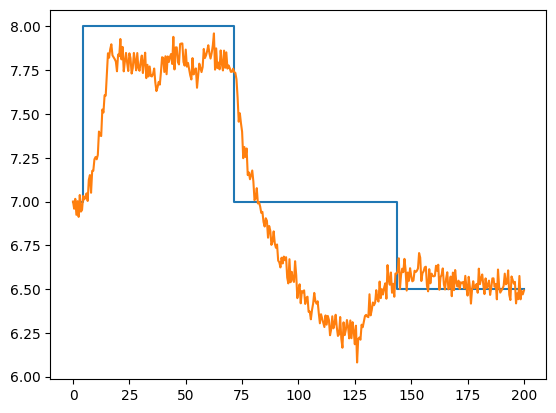

In [70]:
plt.step(t_sim, ysp)
plt.plot(t_sim, Y_gru);

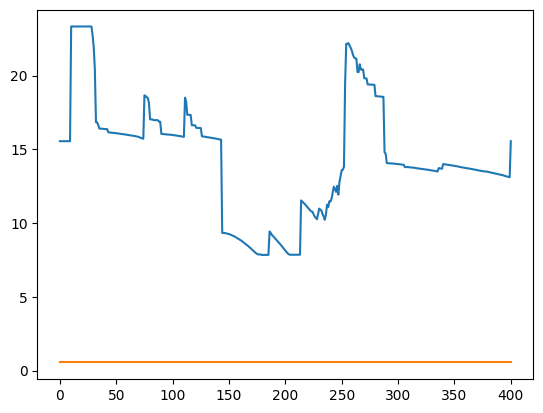

In [72]:
plt.plot(U_gru)